In [18]:
import pandas as pd
import numpy as np
import os
from abnumber import Chain
from Bio import SeqIO
import requests
from io import StringIO
import time
from tqdm import tqdm
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

In [21]:
TASK_DIR = '../../data/tasks/humanness'
PREFIX = os.path.join(TASK_DIR, 'thera_sabdab')

In [3]:
known = list([str(r.seq) for r in SeqIO.parse(os.path.join(TASK_DIR, 'thera_sabdab.fa'), 'fasta')])
len(known), known[0]

(962,
 'EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLEWVSAITWNSGHIDYADSVEGRFTISRDNAKNSLYLQMNSLRAEDTAVYYCAKVSYLSTASSLDYWGQGTLVTVSS')

In [4]:
wanted = list([str(r.seq) for r in SeqIO.parse(os.path.join(TASK_DIR, 'imgt_mab_db.fa'), 'fasta')])
wanted += list([str(r.seq) for r in SeqIO.parse('../../data/tasks/immunogenicity/mabs.fa', 'fasta')])
wanted = sorted(set(wanted).difference(known))
len(wanted), wanted[0]

(197,
 'AIQLTQSPSSLSASVGDRVTITCRASESVEYYGTSLMQWYQQKPGKAPKLLIYAASNVESGVPSRFSGSGSGTDFTLTISSLQPEDFATYFCQQSRKDPSTFGGGTKVEIK')

In [5]:
chains = [Chain(seq, 'imgt') for seq in wanted]
chains[0]

AIQLTQSPSSLSASVGDRVTITCRASESVEYYGTSLMQWYQQKPGKAPKLLIYAASNVESGVPSRFSGSGSGTDFTLTISSLQPEDFATYFCQQSRKDPSTFGGGTKVEIK
                          ^^^^^^^^^^                 ^^^                                    ^^^^^^^^^          

In [13]:
def get_humab_score(chain, jobname='Thanks'):
    data = {
        'h_sequence_score': chain.seq if chain.is_heavy_chain() else '',
        'l_sequence_score': chain.seq if chain.is_light_chain() else '',
        'jobname_score': jobname
    }
    job_request = requests.post('http://opig.stats.ox.ac.uk/webapps/newsabdab/sabpred/humab', data=data)
    jobid = job_request.url.strip('/').split('/')[-1]
    suffix = 'heavy_scores' if chain.is_heavy_chain() else 'light_scores'
    job_url = f'http://opig.stats.ox.ac.uk/webapps/newsabdab/sabpred/humab_results/{jobid}/{jobname}/{suffix}/'
    for retry in range(100):
        result_request = requests.get(job_url)
        time.sleep(retry * 5)
        if result_request.ok:
            text = result_request.text
            break
        else:
            if retry > 10:
                print('Retry', retry+1)
    
    scores = pd.read_csv(StringIO(text.replace('NOT HUMAN','NOT_HUMAN')), sep='\s+', usecols=[0,1])
    return scores['Score'].max()

In [15]:
get_humab_score(
    Chain('QVQLQESGPGLVRPSQTLSLTCTVSGFTFTDFYMNWVRQPPGRGLEWIGFIRDKAKGYTTEYNPSVKGRVTMLVDTSKNQFSLRLSSVTAADTAVYYCAREGHTAAPFDYWGQGSLVTVSS', 'imgt')
)

0.835

In [ ]:
#scores = {}

In [17]:
for chain in tqdm(chains):
    if chain.seq in scores:
        continue
    scores[chain.seq] = get_humab_score(chain)

100%|██████████| 197/197 [1:25:08<00:00, 25.93s/it]


In [20]:
for seq in [
    'EVQLQQSGPELVKPGASVKMSCKASGYTFTSYVVHWVKQNPGQGLEWIGYINPFNDGTKYNENFKGKATLTSDRSSSTAYMELSSLTSEESAVYFCARDMGREGFAYWGQGTLVTVSA',
    'DIVMTQAAFSNPVTLGTSASISCRSSKSLLHSNGITYLYWYLQKPGQSPQLLIYQMSNLASGVPDRFSSSGSGTDFTLRISRVEAEDVGVYYCAQNLELPRTFGGGTKLEI',
    'QVQLVQSGAEVKKPGASVKVSCKASGYIFSNYWIQWVRQAPGQGLEWMGEILPGSGSTEYAQKFQGRVTMTADTSTSTAYMELSSLRSEDTAVYYCARYFFGSSPNWYFVWGQGT',
    'DIQMTQSPSLSASVGDRVTITCGASENIYGALNWYQRKPGKAPKLLIYGATNLADGVPSRFSGSGSGTDYTLTISSLQPEDFATYYCQNVLNTPLTFGQGTKVEIK'
]:
    print(seq in scores)
    if seq in scores:
        continue
    chain = Chain(seq, 'imgt')
    scores[chain.seq] = get_humab_score(chain)

False
False
False
False


/Users/prihodad/Documents/bioinformatics/projects/oas-humanization/condaenv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

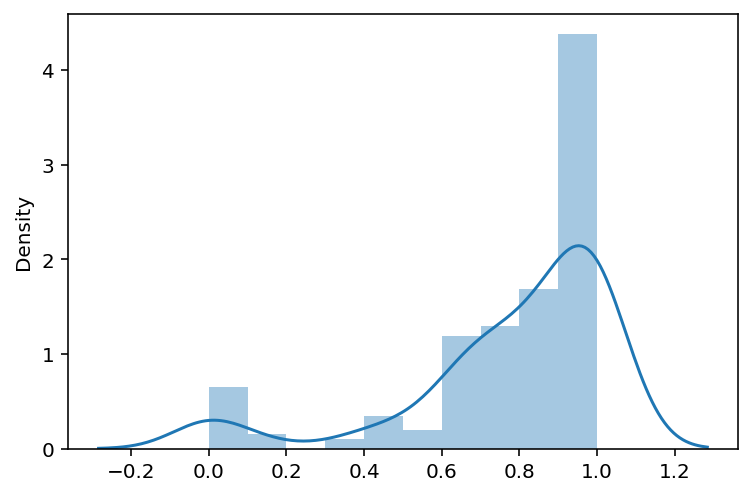

In [22]:
sns.distplot(pd.Series(scores))

In [72]:
immunogenicity_seqs = [str(r.seq) for r in SeqIO.parse('../../data/tasks/immunogenicity/mabs.fa', 'fasta')]
immunogenicity_names = [r.description for r in SeqIO.parse('../../data/tasks/immunogenicity/mabs.fa', 'fasta')]

In [73]:
humanness_seqs = [str(r.seq) for r in SeqIO.parse('../../data/tasks/humanness/imgt_mab_db.fa', 'fasta')]
humanness_names = [r.description for r in SeqIO.parse('../../data/tasks/humanness/imgt_mab_db.fa', 'fasta')]

In [32]:
thera = {str(r.seq): r.description for r in SeqIO.parse('../../data/tasks/humanness/thera_sabdab.fa', 'fasta')}

In [29]:
humab = pd.read_csv('../../data/tasks/humanness/thera_sabdab_humab.tsv', sep='\t', index_col=0)
humab.head()

,Origin,Hu-mAb Score (H),Hu-mAb Class (H),Hu-mAb Score (L),Hu-mAb Class (L)
Therapeutic,,,,,
Adalimumab,u,1.000,V3,0.999,KV1
Afutuzumab,zu,0.830,V1,0.562,Negative
Alemtuzumab,zu,0.835,V4,0.842,KV1
Alirocumab,u,1.000,V3,1.000,KV4
Atezolizumab,zu,0.975,V3,0.941,KV1


In [34]:
heavy_scores = {seq: humab['Hu-mAb Score (H)'].loc[desc.split()[0]] for seq, desc in thera.items() if desc.endswith('VH')}
light_scores = {seq: humab['Hu-mAb Score (L)'].loc[desc.split()[0]] for seq, desc in thera.items() if desc.endswith('VL')}

In [35]:
all_scores = {
    **scores,
    **heavy_scores,
    **light_scores
}

In [74]:
x = pd.Series(all_scores).loc[immunogenicity_seqs]
x.index = immunogenicity_names
x.index.name = 'Antibody'
x.head()

Antibody
3F8 VH            0.00
3F8 VL            0.92
moAb_81C6 VH      0.00
moAb_81C6 VL      0.72
Pexelizumab VH    0.99
dtype: float64

In [78]:
x.rename('Hu-mAb').to_csv('../../data/tasks/immunogenicity/mabs_humab.tsv', sep='\t')

In [76]:
y = pd.Series(all_scores).loc[humanness_seqs]
y.index = humanness_names
y.index.name = 'Antibody'
y.head()

Antibody
8659_seq1     0.000
8659_seq2     0.050
10881_seq1    1.000
10881_seq2    1.000
9509_seq1     0.619
dtype: float64

In [79]:
y.rename('Hu-mAb').to_csv('../../data/tasks/humanness/imgt_mab_db_humab.tsv', sep='\t')

In [ ]:



# TODO TEST duplicate seqs




In [80]:
pd.Series(humanness_seqs)[pd.Series(humanness_seqs).duplicated(keep=False)]

14      DIQMTQSPSSLSASVGDRVTITCRASQGIRNYLAWYQQKPGKAPKL...
15      EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLE...
16      EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLE...
17      DIQMTQSPSSLSASVGDRVTITCRASQGIRNYLAWYQQKPGKAPKL...
40      DIALTQPASVSGSPGQSITISCTGTSSDIGGYNSVSWYQQHPGKAP...
                              ...                        
1117    QVQLVQSGAEVKKPGASVKVSCKASGYTFTNYGMNWVRQAPGQGLK...
1118    DIVMTQSPDSLAVSLGERATINCRASKSVSTSGYSFMHWYQQKPGQ...
1125    QVQLQQSGAEVKKPGASVKVSCEASGYTFPSYVLHWVKQAPGQGLE...
1126    DIQLTQSPSSLSASVGDRVTMTCSASSSVSSSYLYWYQQKPGKAPK...
1139    DIQMTQSPSSLSASVGDRVTITCRASQSISSYLNWYQQKPGKAPKL...
Length: 256, dtype: object

In [62]:
immunogenicity

dict_values(['3F8 VH', '3F8 VL', 'moAb_81C6 VH', 'moAb_81C6 VL', 'Pexelizumab VH', 'Pexelizumab VL', 'Arcitumomab VH', 'Arcitumomab VL', 'Blinatumomab VH', 'Blinatumomab VL', 'Ibritumomab VH', 'Tositumomab VL', 'Zolimomab VH', 'Zolimomab VL', 'Satumomab VH', 'Satumomab VL', 'Tositumomab VH', 'Abciximab VH', 'Abciximab VL', 'Basiliximab VH', 'Basiliximab VL', 'Bavituximab VH', 'Bavituximab VL', 'Cetuximab VH', 'Tomuzotuximab VL', 'Rituximab VH', 'Rituximab VL', 'Siltuximab VH', 'Siltuximab VL', 'Alemtuzumab VH', 'Alemtuzumab VL', 'Atezolizumab VH', 'Atezolizumab VL', 'Bevacizumab VH', 'Bevacizumab VL', 'Certolizumab VH', 'Certolizumab VL', 'Daclizumab VH', 'Daclizumab VL', 'Elotuzumab VH', 'Elotuzumab VL', 'Farletuzumab VH', 'Farletuzumab VL', 'Gemtuzumab VH', 'Gemtuzumab VL', 'Idarucizumab VH', 'Idarucizumab VL', 'Ixekizumab VH', 'Ixekizumab VL', 'Matuzumab VH', 'Matuzumab VL', 'Omalizumab VH', 'Omalizumab VL', 'Oportuzumab VH', 'Oportuzumab VL', 'Pembrolizumab VH', 'Pembrolizumab VL',